In [1]:
import sys
root = '/home/featurize/data'
sys.path.append(f'{root}/pikachu/utils')
sys.path.append(f'{root}/pikachu/third')
sys.path.append(f'{root}/pikachu')
sys.path.append(f'{root}/pikachu/projects/ai/naic_seg')

In [2]:
!pip install -q -r /home/featurize/data/pikachu/projects/ai/naic_seg/requirements.txt

You should consider upgrading via the '/environment/python/versions/3.7.4/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
from IPython.display import display
import os, glob
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd
import gezi
from gezi import tqdm
from gezi.metrics.image.semantic_seg import Evaluator
import melt as mt
from gseg.dataset import Dataset
from gseg.loss import get_loss_fn
from gseg.metrics import get_metrics
from gseg import util
from gseg.util import *
gezi.set_pandas()

In [4]:
CLASSES = ['water', 'track_road', 'build', 'track_airport', 'other_park', 'other_playground', 'arable_natural', 'arable_greenhouse',
           'grass_natural', 'grass_greenbelt', 'forest_natural', 'forest_planted', 'bare_natural', 'bare_planted', 'other_other']
NUM_CLASSES = len(CLASSES)

In [6]:
mt.init_flags()
FLAGS = mt.get_flags()
FLAGS.batch_parse = False
FLAGS.cutmix_range = [0.875, 1.375]
batch_size = 32
batch_size = 16
# batch_size = 8
mt.set_global('batch_size', batch_size) # loss fn used / mt.batch_size()
eval_files = gezi.list_files('../input/quarter/tfrecords/train/1/*')
# eval_files = gezi.list_files('../input/quarter/tfrecords/train/1/21.*')
print(eval_files)
eval_dataset = Dataset('valid').make_batch(batch_size, eval_files)
train_files = gezi.list_files('../input/quarter/tfrecords/train/*/*')
train_files = [x for x in train_files if not x in eval_files]
train_dataset = Dataset('train').make_batch(batch_size, train_files)
train_steps = -(-mt.get_num_records(train_files) // batch_size)
steps = -(-mt.get_num_records(eval_files) // batch_size)
FLAGS.NUM_CLASSES = NUM_CLASSES

['../input/quarter/tfrecords/train/1/1.3334.tfrec', '../input/quarter/tfrecords/train/1/11.3333.tfrec', '../input/quarter/tfrecords/train/1/21.3333.tfrec']


In [7]:
for x, y in train_dataset:
  break

In [13]:
x['image'][0]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ 15.990814,  16.687916,  16.900398],
        [ 28.931486,  29.628586,  29.841068],
        [ 18.66492 ,  14.701542,  20.351242],
        ...,
        [228.0459  , 228.743   , 219.63454 ],
        [195.26286 , 193.62971 , 184.52126 ],
        [163.34254 , 162.48616 , 156.48468 ]],

       [[ 22.029793,  22.726894,  22.939377],
        [ 17.716236,  18.413338,  18.62582 ],
        [ 25.566612,  21.603233,  27.252934],
        ...,
        [207.34082 , 205.70769 , 196.59923 ],
        [196.12558 , 194.49245 , 185.38399 ],
        [163.34254 , 162.48616 , 156.48468 ]],

       [[ 18.578949,  19.27605 ,  19.488533],
        [ 18.578949,  19.27605 ,  19.488533],
        [ 19.52763 ,  15.564255,  21.213955],
        ...,
        [201.30185 , 201.22218 , 191.33699 ],
        [184.0476  , 182.41447 , 173.30602 ],
        [184.0476  , 183.19124 , 177.18974 ]],

       ...,

       [[ 94.32562 ,  95.02272 ,  93.68172 ],
        [ 95.

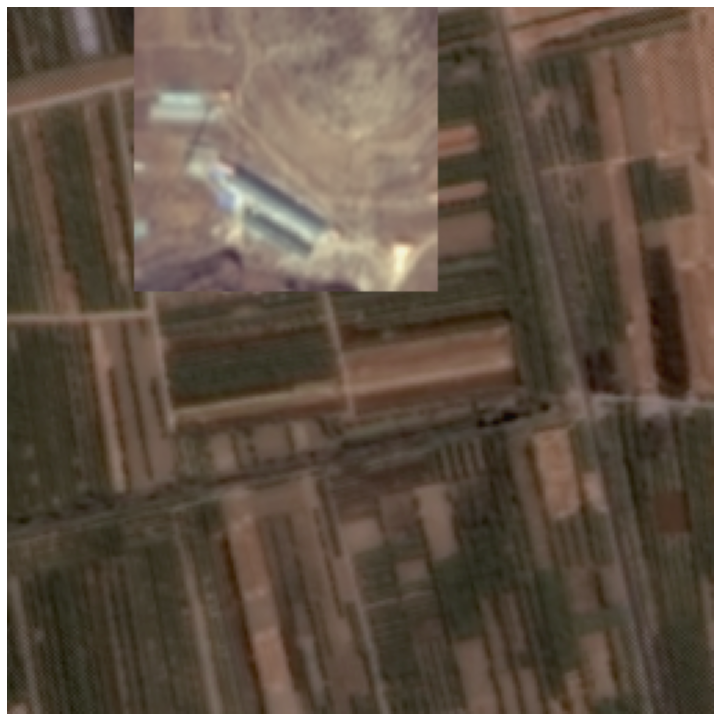

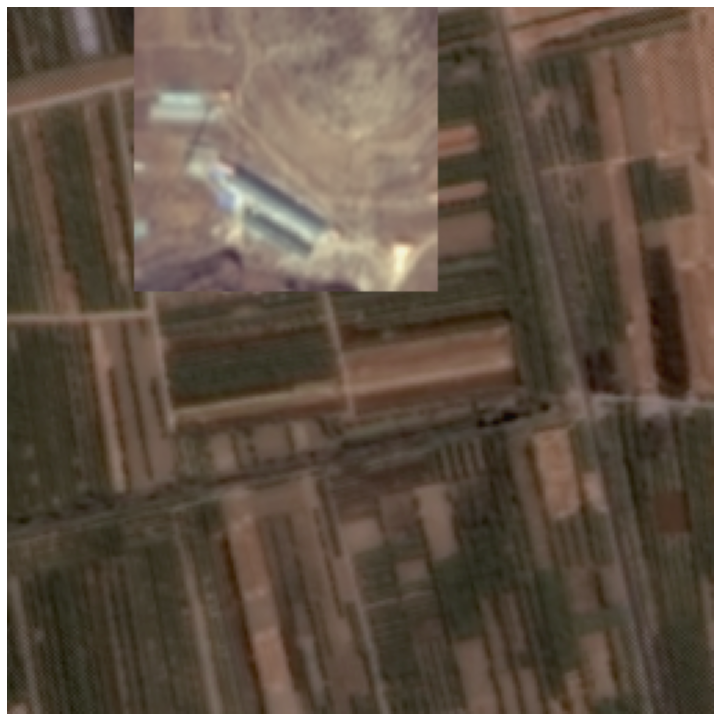

In [18]:
gezi.plot.display_images([(x['image'][14].numpy()).astype(np.uint8)])

In [6]:
def eval(model):
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metrics = get_metrics()
  model.compile('sgd', loss_fn, metrics=metrics)
  res = model.evaluate(eval_dataset, steps=steps, return_dict=True)
#   gezi.pprint_dict(res)
  cm = mt.distributed.sum_merge(metrics[0].get_cm())
  infos = util.get_infos_from_cm(cm, CLASSES)
  res.update(infos)
  return res

In [7]:
cols = ['FWIoU', 'len', 'size', 'time', 'models']
def ensemble(model_dirs, root='../working/convert', tta=True):
  model_bins = ['model', 'model_lr', 'model_ud', 'model_rot1', 'model_rot2', 'model_rot3'] if tta else ['model'] * 6
  model_paths = [f'{model_dirs[i]}/{model_bins[i%(len(model_bins))]}.h5' if os.path.isdir(model_dirs[i]) else f'{root}/{model_dirs[i]}/{model_bins[i%(len(model_bins))]}.h5' for i in range(len(model_dirs))]
  mnames = [x.split('/')[-2] for x in model_paths]
  res = {
    'size': f'{sum([os.path.getsize(x)/1024./1024. for x in model_paths]):.0f}',
    'len': len(mnames),
    'models': '|'.join(mnames)
  }
  print(res)
  info_file = '../working/ensemble/ensemble.csv'
  df = None
  try:
    df = pd.read_csv(info_file)
  except Exception:
    pass
  if df is not None and res['models'] in df.models.values:
    metric = df[df.models==res['models']]['FWIoU'].values[0]
    res['FWIoU'] = f'{metric:.4f}'
    display(df[df.models==res['models']][cols])
    model_path = f'../working/ensemble/model_{res["FWIoU"]}_{res["size"]}.h5'
    if not os.path.exists(model_path): 
      model = mt.EnsembleModel(model_paths).get_model()
      print(f'Save to {model_path}') 
      mt.save_model(model, model_path)
  else:
    model = mt.EnsembleModel(model_paths).get_model()
    timer = gezi.Timer()
    ret = eval(model)
    time = timer.elapsed()
    res['FWIoU'] = f'{ret["FWIoU"]:.4f}'
    res['time'] = f'{time:.0f}'
    gezi.append_df(res, info_file)
    df = pd.read_csv(info_file)[cols]
    display(df.tail(10))
    model_path = f'../working/ensemble/model_{res["FWIoU"]}_{res["size"]}.h5'
    print(f'Save to {model_path}')  
    mt.save_model(model, model_path)

In [19]:
scoring('../working/models.v1/sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122/model.h5', eval)

625/625 [==============================] - 57s 91ms/step - loss: 0.4647 - FWIoU: 0.7654 - MIoU: 0.6977 - ACC/pixel: 0.8644 - ACC/class: 0.7886
water                |true:0.0273 pred:0.0268 acc:0.8799 recall:0.8649 iou:0.7736 fwiou:0.9073|
track_road           |true:0.0767 pred:0.0753 acc:0.8923 recall:0.8757 iou:0.7920 fwiou:0.7606|
build                |true:0.1212 pred:0.1242 acc:0.9128 recall:0.9351 iou:0.8583 fwiou:0.7424|
track_airport        |true:0.0001 pred:0.0000 acc:nan recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0657 acc:0.9269 recall:0.9168 iou:0.8550 fwiou:0.8554|
other_playground     |true:0.0033 pred:0.0031 acc:0.9254 recall:0.8737 iou:0.8162 fwiou:0.9910|
arable_natural       |true:0.2266 pred:0.2320 acc:0.9049 recall:0.9266 iou:0.8443 fwiou:0.4710|
arable_greenhouse    |true:0.0129 pred:0.0128 acc:0.8804 recall:0.8722 iou:0.7798 fwiou:0.9574|
grass_natural        |true:0.1275 pred:0.1264 acc:0.7797 recall:0.7727 iou:0.6343 fwiou:0.30

{'size': 23.35946273803711,
 'size_score': 0.10656214904785158,
 'dur': 58.40876030921936,
 'hours': 1.269755658896073,
 'perf_score': 0.23651221705519634,
 'FWIoU': 0.7653722763061523,
 'metric_score': 0.2796861381530762,
 'score': 0.6227605042561242}

In [90]:
get_score(23.35, 1.28, 0.77)

0.6246

In [91]:
get_score(23.35, 1.28, 0.78)

0.6295999999999999

In [92]:
get_score(23.35, 1.28, 0.7)

0.5895999999999999

In [107]:
get_score(3.2, 1, 0.78)

0.7242000000000001

In [105]:
get_score(6.8/2, 1, 0.58)

0.6234

In [106]:
get_score(15.8/2, 1, 0.72)

0.6754

In [109]:
get_score(3/2, 0.1, 0.6)

0.6859999999999999

In [18]:
scoring('../working/models.v1/sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122/model.h5')

TypeError: scoring() missing 1 required positional argument: 'eval_fn'

In [97]:
model = mt.EnsembleModel([
  '../working/models.v1/sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122/model.h5',
  '../working/models.v1/sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122/model.h5'
]).get_model()
mt.save_model(model, '/tmp/model.h5')

In [98]:
scoring('/tmp/model.h5')

625/625 [==============================] - 99s 158ms/step - loss: 0.4302 - FWIoU: 0.7742 - MIoU: 0.7070 - ACC/pixel: 0.8703 - ACC/class: 0.7939

 +---------+----------+----------+-------------+-------------+
|    loss |    FWIoU |     MIoU |   ACC/pixel |   ACC/class |
|---------+----------+----------+-------------+-------------|
| 0.43019 | 0.774217 | 0.706976 |    0.870312 |      0.7939 |
+---------+----------+----------+-------------+-------------+
water                |true:0.0273 pred:0.0269 acc:0.8858 recall:0.8741 iou:0.7856 fwiou:0.9123|
track_road           |true:0.0767 pred:0.0751 acc:0.8999 recall:0.8808 iou:0.8022 fwiou:0.7724|
build                |true:0.1212 pred:0.1246 acc:0.9144 recall:0.9400 iou:0.8640 fwiou:0.7526|
track_airport        |true:0.0001 pred:0.0000 acc:nan recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0659 acc:0.9320 recall:0.9245 iou:0.8661 fwiou:0.8665|
other_playground     |true:0.0033 pred:0.0030 acc:0.9366 recall:0.8

{'size': 43.765594482421875,
 'size_score': 0.024937622070312495,
 'dur': 101.70360112190247,
 'hours': 2.2109478504761406,
 'perf_score': 0.18945260747619294,
 'FWIoU': 0.7742171287536621,
 'metric_score': 0.2841085643768311,
 'score': 0.4984987939233365}

In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation
def swish_activation(x):
  return (K.sigmoid(x) * x)

class FixedDropout(tf.keras.layers.Dropout):
  def _get_noise_shape(self, inputs):
    if self.noise_shape is None:
      return self.noise_shape

    symbolic_shape = K.shape(inputs)
    noise_shape = [symbolic_shape[axis] if shape is None else shape
                    for axis, shape in enumerate(self.noise_shape)]
    return tuple(noise_shape)

def resize(image, image_size, pad=False):
  return tf.image.resize(image, image_size)

In [14]:
custom_objects={'tf': tf, 
'swish_activation': swish_activation, 
'FixedDropout': FixedDropout,
'relu6': tf.nn.relu6,
'resize': resize,}

In [15]:
model = mt.load_model('../working/v6/deeplabv3plus-eff0/model.h5', custom_objects=custom_objects)

In [16]:
ret = eval(model)

625/625 [==============================] - 25s 39ms/step - loss: 0.9302 - FWIoU: 0.5268 - MIoU: 0.3988 - ACC/pixel: 0.6810 - ACC/class: 0.5432
water                |true:0.0273 pred:0.0357 acc:0.5914 recall:0.7745 iou:0.5045 fwiou:0.7972|
track_road           |true:0.0767 pred:0.0822 acc:0.6510 recall:0.6980 iou:0.5079 fwiou:0.4338|
build                |true:0.1212 pred:0.1310 acc:0.7802 recall:0.8431 iou:0.6813 fwiou:0.4204|
track_airport        |true:0.0001 pred:0.0000 acc:nan recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0713 acc:0.6014 recall:0.6449 iou:0.4518 fwiou:0.4534|
other_playground     |true:0.0033 pred:0.0000 acc:0.8780 recall:0.0001 iou:0.0001 fwiou:0.9511|
arable_natural       |true:0.2266 pred:0.2465 acc:0.8291 recall:0.9021 iou:0.7607 fwiou:0.1866|
arable_greenhouse    |true:0.0129 pred:0.0140 acc:0.7660 recall:0.8316 iou:0.6632 fwiou:0.9348|
grass_natural        |true:0.1275 pred:0.0818 acc:0.6684 recall:0.4288 iou:0.3536 fwiou:-0.2

In [19]:
import tensorflow_model_optimization as tfmot

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 16,
  'cluster_centroids_init': CentroidInitialization.LINEAR
}

# Cluster a whole model
clustered_model = cluster_weights(model, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=opt,
  metrics=['accuracy'])

clustered_model.summary()

ValueError: Please initialize `Cluster` with a supported layer. Layers should either be a `ClusterableLayer` instance, or should be supported by the ClusteringRegistry. You passed: <class 'tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer'>

In [17]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(trian_dataset,
                  batch_size=batch_size, epochs=epochs, validation_data=valid_dataset,
                  callbacks=callbacks)

NameError: name 'tempfile' is not defined

In [ ]:
model = mt.load_model('/home/featurize/work/submit_1125_1/model.h5')
ret = eval(model)

In [ ]:
## 0.785861 278s  7h online 278 * 1.6 = 444 with about 11h online so better to be 400s
# ret = eval(model)

In [ ]:
df = pd.read_csv('../working/ensemble/ensemble.csv')[cols]
df.tail(20)

In [ ]:
df = pd.read_csv('../working/ensemble/ensemble.csv')[cols]
df.tail(20)

In [ ]:
# df.models.values[29].split('|')

In [ ]:
323 / 278 * 7

In [ ]:
# 11.25 student ensemble model
model_dirs = [
 'sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120',
 'sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117',
 'sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122',
 'sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122',
 'sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117',
 'sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123'
]
ensemble(model_dirs)

In [ ]:
# 11.25 teacher ensemble model
model_dirs = [
 'sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120',
 'sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117',
 'sm.Unet.EfficientNetB3.augl4.size288.mrate1.300epoch.largefilter.1124',
 'sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122',
 'sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122',
 'sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122',
 'sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117',
 'sm.FPN.EfficientNetB5.augl4.size256.mrate1.200epoch.1115',
 'sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123',
 'sm.Linknet.EfficientNetB5.augl4.size256.mrate1.300epoch.largefilter.1123',
 'bread.DeepLabV3Plus.EfficientNetB6.augl3.size256.mrate0.300epoch.1122',
]
ensemble(model_dirs)

In [12]:
model = mt.load_model('/home/featurize/work/naicseg/models/sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0/model.h5')
ret = eval(model)

625/625 [==============================] - 84s 134ms/step - loss: 0.4202 - FWIoU: 0.7821 - MIoU: 0.7175 - ACC/pixel: 0.8754 - ACC/class: 0.8023

 +----------+----------+----------+-------------+-------------+
|     loss |    FWIoU |     MIoU |   ACC/pixel |   ACC/class |
|----------+----------+----------+-------------+-------------|
| 0.420185 | 0.782117 | 0.717503 |    0.875386 |    0.802317 |
+----------+----------+----------+-------------+-------------+
water                |true:0.0273 pred:0.0269 acc:0.8933 recall:0.8792 iou:0.7956 fwiou:0.9164|
track_road           |true:0.0767 pred:0.0755 acc:0.9034 recall:0.8887 iou:0.8116 fwiou:0.7832|
build                |true:0.1212 pred:0.1241 acc:0.9174 recall:0.9387 iou:0.8655 fwiou:0.7554|
track_airport        |true:0.0001 pred:0.0000 acc:0.0000 recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0660 acc:0.9422 recall:0.9351 iou:0.8844 fwiou:0.8847|
other_playground     |true:0.0033 pred:0.0031 acc:0.9448 re

In [14]:
model = mt.load_model('/home/featurize/work/naicseg/models/sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0/model.h5')
ret = eval(model)

625/625 [==============================] - 71s 113ms/step - loss: 0.4169 - FWIoU: 0.7792 - MIoU: 0.7134 - ACC/pixel: 0.8736 - ACC/class: 0.8000

 +----------+----------+---------+-------------+-------------+
|     loss |    FWIoU |    MIoU |   ACC/pixel |   ACC/class |
|----------+----------+---------+-------------+-------------|
| 0.416931 | 0.779218 | 0.71345 |    0.873603 |    0.799961 |
+----------+----------+---------+-------------+-------------+
water                |true:0.0273 pred:0.0268 acc:0.8924 recall:0.8763 iou:0.7926 fwiou:0.9151|
track_road           |true:0.0767 pred:0.0753 acc:0.9020 recall:0.8850 iou:0.8074 fwiou:0.7784|
build                |true:0.1212 pred:0.1242 acc:0.9153 recall:0.9375 iou:0.8627 fwiou:0.7502|
track_airport        |true:0.0001 pred:0.0000 acc:0.0000 recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0663 acc:0.9373 recall:0.9343 iou:0.8793 fwiou:0.8797|
other_playground     |true:0.0033 pred:0.0031 acc:0.9398 recall:

In [18]:
model = mt.load_model('/home/featurize/work/naicseg/models/sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0/model.h5')
ret = eval(model)

625/625 [==============================] - 69s 110ms/step - loss: 0.4117 - FWIoU: 0.7786 - MIoU: 0.7135 - ACC/pixel: 0.8732 - ACC/class: 0.8006

 +----------+----------+----------+-------------+-------------+
|     loss |    FWIoU |     MIoU |   ACC/pixel |   ACC/class |
|----------+----------+----------+-------------+-------------|
| 0.411654 | 0.778572 | 0.713488 |    0.873175 |     0.80056 |
+----------+----------+----------+-------------+-------------+
water                |true:0.0273 pred:0.0269 acc:0.8898 recall:0.8777 iou:0.7917 fwiou:0.9147|
track_road           |true:0.0767 pred:0.0755 acc:0.8993 recall:0.8850 iou:0.8052 fwiou:0.7759|
build                |true:0.1212 pred:0.1250 acc:0.9124 recall:0.9406 iou:0.8627 fwiou:0.7504|
track_airport        |true:0.0001 pred:0.0000 acc:0.0000 recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0660 acc:0.9384 recall:0.9317 iou:0.8780 fwiou:0.8784|
other_playground     |true:0.0033 pred:0.0032 acc:0.9269 re

In [24]:
# # 这个模型有问题 速度超级慢 需要重跑一下 似乎是FP16 model.save的问题 B2是按fp16跑的 可以干脆为了简单不用fp16 或者save之前切换float32
# mt.set_fp16_policy()
# model = mt.load_model('/home/featurize/work/naicseg/models/sm.Unet.EfficientNetB2.size352.aug7.bs32.cutmix1.0/model.h5')
# ret = eval(model)

In [15]:
model = mt.EnsembleModel([
  '/home/featurize/work/naicseg/models/sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0/model.h5',
  '/home/featurize/work/naicseg/models/sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0/model.h5',
])
ret = eval(model)


625/625 [==============================] - 132s 212ms/step - loss: 0.3905 - FWIoU: 0.7892 - MIoU: 0.7250 - ACC/pixel: 0.8801 - ACC/class: 0.8063

 +----------+----------+----------+-------------+-------------+
|     loss |    FWIoU |     MIoU |   ACC/pixel |   ACC/class |
|----------+----------+----------+-------------+-------------|
| 0.390475 | 0.789214 | 0.725046 |     0.88009 |    0.806332 |
+----------+----------+----------+-------------+-------------+
water                |true:0.0273 pred:0.0269 acc:0.8976 recall:0.8834 iou:0.8025 fwiou:0.9192|
track_road           |true:0.0767 pred:0.0753 acc:0.9083 recall:0.8914 iou:0.8178 fwiou:0.7904|
build                |true:0.1212 pred:0.1243 acc:0.9182 recall:0.9415 iou:0.8686 fwiou:0.7611|
track_airport        |true:0.0001 pred:0.0000 acc:nan recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0661 acc:0.9452 recall:0.9393 iou:0.8908 fwiou:0.8911|
other_playground     |true:0.0033 pred:0.0031 acc:0.9520 rec

In [21]:
# 0.7872 -> 0.5809
# 0.7941
model_dirs = [
 'sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0',
 'sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0',
 'sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0',
#  'sm.Unet.EfficientNetB2.size352.aug7.bs32.cutmix1.0',
 'sm.FPN.EfficientNetB4.size256.aug7.bs32.cutmix1.0',
 'sm.Linknet.EfficientNetB5.size256.aug7.bs32.cutmix1.0.mrate0',
#  'sm.FPN.EfficientNetB5.size256.aug7.bs32.cutmix1.0',
]
ensemble(model_dirs, root='../working/models', tta=False)

{'size': '571', 'len': 5, 'models': 'sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0|sm.FPN.EfficientNetB4.size256.aug7.bs32.cutmix1.0|sm.Linknet.EfficientNetB5.size256.aug7.bs32.cutmix1.0.mrate0'}



625/625 [==============================] - 284s 455ms/step - loss: 0.3700 - FWIoU: 0.7941 - MIoU: 0.7311 - ACC/pixel: 0.8833 - ACC/class: 0.8102

 +----------+----------+----------+-------------+-------------+
|     loss |    FWIoU |     MIoU |   ACC/pixel |   ACC/class |
|----------+----------+----------+-------------+-------------|
| 0.369973 | 0.794142 | 0.731133 |     0.88331 |     0.81025 |
+----------+----------+----------+-------------+-------------+
water                |true:0.0273 pred:0.0269 acc:0.9008 recall:0.8866 iou:0.8078 fwiou:0.9213|
track_road           |true:0.0767 pred:0.0753 acc:0.9103 recall:0.8932 iou:0.8209 fwiou:0.7939|
build                |true:0.1212 pred:0.1248 acc:0.9180 recall:0.9449 iou:0.8714 fwiou:0.7661|
track_airport        |true:0.0001 pred:0.0000 acc:nan recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0661 acc:0.9473 recall:0.9416 iou:0.8948 fwiou:0.8951|
other_playground     |true:0.0033 pred:0.0031 acc:0.9538 rec

,FWIoU,len,size,time,models
0,0.7872,6.0,532,323,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123
1,0.7861,6.0,414,305,sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123
2,0.7865,7.0,495,339,sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size288.mrate1.300epoch.largefilter.1124|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123
3,0.7866,8.0,539,379,sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size288.mrate1.300epoch.largefilter.1124|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123|sm.Linknet.EfficientNetB2.augl4.size320.mrate1.300ep...
4,0.7864,7.0,543,342,sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size288.mrate1.300epoch.largefilter.1124|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB5.augl4.size256.mrate1.300epoch.largefilter.1123
5,0.7868,6.0,527,320,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123
6,0.7871,6.0,526,323,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size320.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123
7,0.7861,6.0,543,320,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|
8,0.7885,11.0,1113,589,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size288.mrate1.300epoch.largefilter.1124|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.FPN.EfficientNetB5.augl4.size256.mrate1.200epoch.11...
9,0.7941,5.0,571,296,sm.Unet.EfficientNetB5.size288.aug

Save to ../working/ensemble/model_0.7941_571.h5


In [31]:
model_dirs = [
 'sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0',
 'sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0',
 'sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0',
 'sm.Unet.EfficientNetB2.size352.aug7.bs32.cutmix1.0',
 'sm.FPN.EfficientNetB4.size256.aug7.bs32.cutmix1.0',
 'sm.Linknet.EfficientNetB5.size256.aug7.bs32.cutmix1.0.mrate0',
 'sm.FPN.EfficientNetB5.size256.aug7.bs32.cutmix1.0',
]
ensemble(model_dirs, root='../working/models', tta=False)

{'size': '760', 'len': 7, 'models': 'sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB2.size352.aug7.bs32.cutmix1.0|sm.FPN.EfficientNetB4.size256.aug7.bs32.cutmix1.0|sm.Linknet.EfficientNetB5.size256.aug7.bs32.cutmix1.0.mrate0|sm.FPN.EfficientNetB5.size256.aug7.bs32.cutmix1.0'}



625/625 [==============================] - 418s 669ms/step - loss: 0.3656 - FWIoU: 0.7953 - MIoU: 0.7323 - ACC/pixel: 0.8841 - ACC/class: 0.8111

 +----------+----------+----------+-------------+-------------+
|     loss |    FWIoU |     MIoU |   ACC/pixel |   ACC/class |
|----------+----------+----------+-------------+-------------|
| 0.365571 | 0.795303 | 0.732305 |    0.884067 |    0.811108 |
+----------+----------+----------+-------------+-------------+
water                |true:0.0273 pred:0.0269 acc:0.9013 recall:0.8877 iou:0.8091 fwiou:0.9219|
track_road           |true:0.0767 pred:0.0752 acc:0.9111 recall:0.8935 iou:0.8219 fwiou:0.7950|
build                |true:0.1212 pred:0.1248 acc:0.9185 recall:0.9452 iou:0.8721 fwiou:0.7673|
track_airport        |true:0.0001 pred:0.0000 acc:nan recall:0.0000 iou:0.0000 fwiou:0.9991|
other_park           |true:0.0665 pred:0.0661 acc:0.9476 recall:0.9421 iou:0.8955 fwiou:0.8958|
other_playground     |true:0.0033 pred:0.0031 acc:0.9545 rec

,FWIoU,len,size,time,models
3,0.7866,8.0,539,379,sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size288.mrate1.300epoch.largefilter.1124|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123|sm.Linknet.EfficientNetB2.augl4.size320.mrate1.300ep...
4,0.7864,7.0,543,342,sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size288.mrate1.300epoch.largefilter.1124|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB5.augl4.size256.mrate1.300epoch.largefilter.1123
5,0.7868,6.0,527,320,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123
6,0.7871,6.0,526,323,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size320.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.Linknet.EfficientNetB4.augl4.size288.mrate1.300epoch.largefilter.1123
7,0.7861,6.0,543,320,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|
8,0.7885,11.0,1113,589,sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120|sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117|sm.Unet.EfficientNetB3.augl4.size288.mrate1.300epoch.largefilter.1124|sm.Unet.EfficientNetB2.augl4.size352.mrate1.300epoch.1122|sm.Unet.EfficientNetB2.augl4.size320.mrate1.300epoch.largefilter.1122|sm.Unet.EfficientNetB1.augl4.size352.mrate1.300epoch.1122|sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117|sm.FPN.EfficientNetB5.augl4.size256.mrate1.200epoch.11...
9,0.7941,5.0,571,296,sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0|sm.FPN.EfficientNetB4.size256.aug7.bs32.cutmix1.0|sm.Linknet.EfficientNetB5.size256.aug7.bs32.cutmix1.0.mrate0
10,0.7948,6.0,694,362,sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0|sm.FPN.EfficientNetB4.size256.aug7.bs32.cutmix1.0|sm.Linknet.EfficientNetB5.size256.aug7.bs32.cutmix1.0.mrate0|sm.FPN.EfficientNetB5.size256.aug7.bs32.cutmix1.0
11,0.7952,6.0,679,351,sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB2.size352.aug7.bs32.cutmix1.0|sm.Linknet.EfficientNetB5.size256.aug7.bs32.cutmix1.0.mrate0|sm.FPN.EfficientNetB5.size256.aug7.bs32.cutmix1.0
12,0.7953,7.0,760,434,sm.Unet.EfficientNetB5.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB4.size288.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB3.size320.aug7.bs32.cutmix1.0|sm.Unet.EfficientNetB2.size352.aug7.bs32.cutmix1.0|sm.FPN.EfficientNetB4.size256.aug7.bs32.cutmix1.0|sm.Linknet.EfficientNetB5.size256.aug7.bs32.cutmix1.0.mrate0|sm.FPN.EfficientNetB5.size25

Save to ../working/ensemble/model_0.7953_760.h5


In [ ]:
abcdef

In [ ]:
!ls ../working/ensemble

In [ ]:
# from tensorflow_model_optimization.sparsity import keras as sparsity
# epochs = 4
# new_pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.90, begin_step=0, end_step= train_steps * epochs, frequency=100)}
# new_pruned_model = sparsity.prune_low_magnitude(model, new_pruning_params)
# new_pruned_model.summary()
# new_pruned_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=get_metrics())

# callbacks = [sparsity.UpdatePruningStep(), sparsity.PruningSummaries(log_dir=logdir, profile_batch=0)]
# new_pruned_model.fit(train_dataset, batch_size=8,  epochs=epochs, verbose=1, callbacks=callbacks, validation_data=eval_dataset)
# score = new_pruned_model.evaluate(eval_dataset, steps=steps)

In [ ]:
# model_paths = [
#   '../working/convert/sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.1120/model_rot2.h5',
#   '../working/convert/sm.Unet.EfficientNetB5.augl4.size288.mrate1.300epoch.largefilters.1120/model_rot3.h5',
#   '../working/convert/sm.FPN.EfficientNetB4.augl4.size256.mrate1.300epoch.1117/model.h5',
#   '../working/convert/bread.DeeplabV3Plus.EfficientNetB6.augl3.size256.200epoch/model.h5',
#   '../working/convert/sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.1117/model_rot1.h5',
#   '../working/convert/sm.Unet.EfficientNetB7.augl4.size256.mrate0.300epoch.1117/model_ud.h5',
#   '../working/convert/sm.FPN.EfficientNetB6.augl3.200epoch/model_lr.h5',
#   '../working/convert/sm.Unet.EfficientNetB4.augl4.size288.mrate1.300epoch.bluronly.1120/model_lr.h5',
# ]
# models = []
# for model_path in tqdm(model_paths):
#   model = mt.load_model(model_path)
#   models.append(model)
# model = mt.EnsembleModel(models).get_model()
# model.summary()

In [ ]:
input_ = model.input
output_ = tf.reduce_mean(tf.reduce_sum(-tf.math.log(tf.math.softmax(model(model.input), -1)), -1), [1, 2])
info_model = tf.keras.Model(input_, output_)

In [ ]:
infos = info_model.predict(eval_dataset, steps=steps, verbose=1)

In [ ]:
losses = []
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
for x, info in tqdm(zip(eval_dataset.unbatch().batch(1), infos), total=len(infos)):
  loss = tf.reduce_mean(loss_fn(x[1], model.predict_on_batch(x[0])), [1, 2])
  losses.append(loss)

In [ ]:
l = []
for x, info, loss in tqdm(zip(eval_dataset.unbatch().batch(1), infos, losses), total=len(infos)):
  l.append([x[0]['id'][0][0].numpy(), info, loss[0].numpy()])

In [ ]:
# l2 = sorted(l, reverse=True, key=lambda x: x[-1])
# l2 = [x for x in l2 if x[1] > 79]
# l2

In [ ]:
# sorted(l, key=lambda x: x[1])

In [ ]:
model = mt.load_model('/home/featurize/work/submit_1123_2/model.h5')
model.summary()